In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler,scale
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 256
use_gpu = True
y_scale = True
lr = 0.001
weight_decay = 0.01

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')


columns = X.columns


In [6]:
columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

## Imputer, Scaler, Feature selection

In [7]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2])


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)
X_test = X_test.drop(columns=['building_id'], axis=1)


### X sacle

In [9]:
X = pipeline.fit_transform(X)
print(X.shape)

X_test = pipeline.fit_transform(X_test)
print(X_test.shape)

(60000, 233)
(10000, 233)


In [10]:
#X = pd.DataFrame(X, columns=columns)

### y scale 

In [11]:
y_scaler = MinMaxScaler()
if y_scale:
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))



In [13]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

In [14]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 233])
torch.Size([10000, 233])
torch.Size([42000, 1])


In [16]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [17]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(233, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [18]:
model = DNN().to(device)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [19]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return np.array(train_loss).mean()




def eval_func(model, loader):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            
            eval_loss.append(loss.item())
        print('testing loss', np.array(eval_loss).mean())
    return np.array(eval_loss).mean()

def test_func(model, X):
    model.eval()
    
    with torch.no_grad():
        pred = model(X)
        pred = pred.cpu().numpy()
        
        if y_scale:
            pred = y_scaler.inverse_transform(pred)
            
    return pred


def accuracy(model, pct_close=0.5):
    #pred, y_eval
    model.eval()
    with torch.no_grad():
        pred = model(X_eval)
        
    n_correct = torch.sum((torch.abs(pred - y_eval) < torch.abs(pct_close * y_eval)))
    result = (n_correct.item()/len(y_eval))  # scalar
    return result 

def plot(label, pred):
    plt.plot(label, label='actual')
    plt.plot(pred, label='pred')
    plt.legend(frameon=False)
    

In [22]:
train_losses = []
eval_losses = []
accs = []
for t in range(2000):
    print('epochs', t)
    train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        #acc = accuracy(model)
        
        eval_losses.append(eval_loss)
        train_losses.append(train_loss)
        
        #accs.append(acc)
        #print('accuracy: ',acc)

epochs 0
training loss 1.2192955681243665e-05
epochs 1
training loss 2.163040376493e-05
epochs 2
training loss 1.078804142790349e-05
epochs 3
training loss 1.0974154645626903e-05
epochs 4
training loss 9.792519216661634e-06
epochs 5
training loss 9.983207271282232e-06
epochs 6
training loss 1.0112592006848761e-05
epochs 7
training loss 3.503701847021699e-05
epochs 8
training loss 2.046368482627837e-05
epochs 9
training loss 1.2694751115194584e-05
testing loss 7.062092287258206e-05
epochs 10
training loss 9.82657139281924e-06
epochs 11
training loss 9.206050822974772e-06
epochs 12
training loss 3.6740472645154416e-05
epochs 13
training loss 1.288205534172338e-05
epochs 14
training loss 1.3224755675213545e-05
epochs 15
training loss 1.15798543385443e-05
epochs 16
training loss 1.1278423598372627e-05
epochs 17
training loss 3.411418117111404e-05
epochs 18
training loss 2.211970578228471e-05
epochs 19
training loss 1.3669178668241137e-05
testing loss 6.634011421904777e-05
epochs 20
trainin

training loss 2.6506807922267014e-05
epochs 165
training loss 6.818382179875643e-05
epochs 166
training loss 1.7619699459222223e-05
epochs 167
training loss 1.0423988473893119e-05
epochs 168
training loss 6.294344993048898e-06
epochs 169
training loss 6.435537611513141e-06
testing loss 6.37335105347773e-05
epochs 170
training loss 6.054688730149461e-06
epochs 171
training loss 5.669486785281509e-06
epochs 172
training loss 5.647559650049406e-06
epochs 173
training loss 5.372000664189699e-06
epochs 174
training loss 5.530446787126879e-06
epochs 175
training loss 5.33311675195419e-06
epochs 176
training loss 5.560746379187824e-06
epochs 177
training loss 5.353964928817181e-06
epochs 178
training loss 5.57273738815473e-06
epochs 179
training loss 5.998937092844051e-06
testing loss 5.913149330923953e-05
epochs 180
training loss 5.555780098527038e-06
epochs 181
training loss 5.373559569803051e-06
epochs 182
training loss 6.951246989432768e-06
epochs 183
training loss 7.448462295569974e-06
e

training loss 4.91118710490837e-06
epochs 327
training loss 4.763372460343596e-06
epochs 328
training loss 4.073986866442834e-06
epochs 329
training loss 4.265425870168353e-06
testing loss 5.5173369209511856e-05
epochs 330
training loss 4.126580090473219e-06
epochs 331
training loss 4.32634820809295e-06
epochs 332
training loss 4.769716996854571e-06
epochs 333
training loss 3.917611396983292e-06
epochs 334
training loss 4.565435010866195e-06
epochs 335
training loss 4.1281378833335825e-06
epochs 336
training loss 5.543815736376873e-06
epochs 337
training loss 5.462489006772971e-06
epochs 338
training loss 5.009240706068808e-06
epochs 339
training loss 4.5309662675318774e-06
testing loss 5.482830831592572e-05
epochs 340
training loss 3.8828958925781386e-06
epochs 341
training loss 6.047063707779726e-06
epochs 342
training loss 4.3954817204972976e-06
epochs 343
training loss 5.2725712672933396e-06
epochs 344
training loss 4.0349045520722e-06
epochs 345
training loss 5.539741565977844e-06

training loss 1.2084671286147293e-05
epochs 489
training loss 1.34314078512475e-05
testing loss 5.069960243545979e-05
epochs 490
training loss 4.77262585098453e-06
epochs 491
training loss 2.7001878134852272e-06
epochs 492
training loss 2.070703170154571e-06
epochs 493
training loss 1.97403379202528e-06
epochs 494
training loss 2.181130182152353e-06
epochs 495
training loss 2.2769464911134765e-06
epochs 496
training loss 2.078583108386462e-06
epochs 497
training loss 2.0028409490998566e-06
epochs 498
training loss 2.0992965622126853e-06
epochs 499
training loss 2.1344591273604732e-06
testing loss 4.92562503751915e-05
epochs 500
training loss 2.500580541381527e-06
epochs 501
training loss 2.2468041861705416e-06
epochs 502
training loss 2.4362511601683573e-06
epochs 503
training loss 2.10572974207356e-06
epochs 504
training loss 1.9363208114996133e-06
epochs 505
training loss 2.3114209246462752e-06
epochs 506
training loss 2.5454768946832645e-06
epochs 507
training loss 2.031156670358486

training loss 1.992543083030217e-06
testing loss 4.762637002892314e-05
epochs 650
training loss 1.7401559678849785e-06
epochs 651
training loss 1.8441067771329306e-06
epochs 652
training loss 1.7094182470772826e-06
epochs 653
training loss 1.8578242306279153e-06
epochs 654
training loss 2.976912087020041e-06
epochs 655
training loss 2.0734742036259402e-06
epochs 656
training loss 1.6865784335674438e-06
epochs 657
training loss 1.836205120236462e-06
epochs 658
training loss 2.3449350530399624e-06
epochs 659
training loss 4.8714642344527945e-06
testing loss 5.551036162332949e-05
epochs 660
training loss 2.6189682951856715e-05
epochs 661
training loss 1.0390478428234928e-05
epochs 662
training loss 8.45547223517232e-06
epochs 663
training loss 5.402451300583242e-06
epochs 664
training loss 4.376285640760078e-06
epochs 665
training loss 3.672383892687018e-06
epochs 666
training loss 3.179201850357596e-06
epochs 667
training loss 2.809002932157124e-06
epochs 668
training loss 2.942873812351

training loss 2.057817139853851e-06
epochs 811
training loss 1.5742438125871008e-06
epochs 812
training loss 2.244861505143049e-06
epochs 813
training loss 2.0343072416532475e-06
epochs 814
training loss 2.5280877246063247e-06
epochs 815
training loss 3.0308375006494646e-06
epochs 816
training loss 2.9641293313929825e-06
epochs 817
training loss 3.3990716725852645e-06
epochs 818
training loss 2.1688830434579192e-06
epochs 819
training loss 1.947258603553509e-06
testing loss 4.412766450891916e-05
epochs 820
training loss 1.9587894974282595e-06
epochs 821
training loss 1.791389318193317e-06
epochs 822
training loss 1.6663137390685622e-06
epochs 823
training loss 1.5506789154504518e-06
epochs 824
training loss 1.9355956920442238e-06
epochs 825
training loss 1.998922725692175e-06
epochs 826
training loss 2.048514854226541e-06
epochs 827
training loss 2.2388681644990743e-06
epochs 828
training loss 1.8191926005094888e-06
epochs 829
training loss 1.6375059830710542e-06
testing loss 4.5953262

training loss 1.6429226720350871e-06
epochs 972
training loss 1.5502215863748324e-06
epochs 973
training loss 1.4303220632083332e-06
epochs 974
training loss 1.3122748734503781e-06
epochs 975
training loss 1.5063296679975543e-06
epochs 976
training loss 4.252883885866058e-06
epochs 977
training loss 1.9030463378881408e-06
epochs 978
training loss 1.2528715880459155e-06
epochs 979
training loss 1.4540338010206279e-06
testing loss 4.40336436975511e-05
epochs 980
training loss 1.6678861549845544e-06
epochs 981
training loss 1.6966252017578936e-06
epochs 982
training loss 9.258032238531913e-06
epochs 983
training loss 7.266958807645786e-06
epochs 984
training loss 2.6841575370119907e-06
epochs 985
training loss 2.0034782237692553e-06
epochs 986
training loss 1.8354755377114282e-06
epochs 987
training loss 2.214539534689362e-06
epochs 988
training loss 1.5948383448134832e-06
epochs 989
training loss 1.5722092657046177e-06
testing loss 4.3459739511580294e-05
epochs 990
training loss 1.552684

training loss 1.2216155698063107e-06
epochs 1131
training loss 1.2691862717805304e-06
epochs 1132
training loss 1.5221389978912406e-06
epochs 1133
training loss 1.7898060684384484e-06
epochs 1134
training loss 1.526003558010967e-06
epochs 1135
training loss 5.5674460578770915e-06
epochs 1136
training loss 2.5314730488858142e-06
epochs 1137
training loss 1.6574151411050204e-06
epochs 1138
training loss 1.4784794419745484e-06
epochs 1139
training loss 1.2872849245495949e-06
testing loss 9.967582485775034e-05
epochs 1140
training loss 1.0901174798136433e-06
epochs 1141
training loss 1.1157234008819751e-06
epochs 1142
training loss 1.1675516571868325e-06
epochs 1143
training loss 1.20941291074263e-06
epochs 1144
training loss 1.2703510540659685e-06
epochs 1145
training loss 2.629303186509016e-06
epochs 1146
training loss 1.9587150737179675e-06
epochs 1147
training loss 1.6022977754139653e-06
epochs 1148
training loss 5.6732264976166e-06
epochs 1149
training loss 1.8127930706779092e-05
test

training loss 1.4037955645218255e-06
epochs 1289
training loss 1.3762804511233381e-06
testing loss 4.2613545081423296e-05
epochs 1290
training loss 1.4743113044088121e-06
epochs 1291
training loss 2.2101599962766297e-06
epochs 1292
training loss 4.292403895595436e-06
epochs 1293
training loss 2.388932658146642e-06
epochs 1294
training loss 1.708283020958113e-06
epochs 1295
training loss 3.4549516557848565e-06
epochs 1296
training loss 1.4084376055672527e-05
epochs 1297
training loss 9.671640910627585e-06
epochs 1298
training loss 3.678939708262271e-06
epochs 1299
training loss 2.9927807517968616e-06
testing loss 4.00859931898953e-05
epochs 1300
training loss 2.107370102928116e-06
epochs 1301
training loss 1.7037859616190569e-06
epochs 1302
training loss 1.6376159275447814e-06
epochs 1303
training loss 1.5744173031800363e-06
epochs 1304
training loss 1.7836622494845263e-06
epochs 1305
training loss 1.5696004269192131e-06
epochs 1306
training loss 1.5249522482807868e-06
epochs 1307
train

training loss 1.344897158918629e-06
epochs 1447
training loss 1.1628019682107014e-06
epochs 1448
training loss 1.2044077824281306e-06
epochs 1449
training loss 1.216943346180139e-06
testing loss 3.999039750438692e-05
epochs 1450
training loss 1.4108791739972454e-06
epochs 1451
training loss 6.918936984137955e-06
epochs 1452
training loss 3.334363963693415e-05
epochs 1453
training loss 5.0363098065038985e-05
epochs 1454
training loss 1.850553731635569e-05
epochs 1455
training loss 8.645901894080012e-06
epochs 1456
training loss 8.25602211961902e-06
epochs 1457
training loss 6.127803550787741e-06
epochs 1458
training loss 5.482751001898467e-06
epochs 1459
training loss 4.852253407465689e-06
testing loss 4.032452644539044e-05
epochs 1460
training loss 4.4235852693887095e-06
epochs 1461
training loss 4.313394963377725e-06
epochs 1462
training loss 4.443404064300976e-06
epochs 1463
training loss 4.078836401056447e-06
epochs 1464
training loss 3.7170751883505464e-06
epochs 1465
training loss

training loss 1.3126775956372899e-06
epochs 1605
training loss 1.902868066763679e-06
epochs 1606
training loss 1.6027636427156033e-06
epochs 1607
training loss 1.2303192699453741e-06
epochs 1608
training loss 4.971721085839266e-06
epochs 1609
training loss 3.020798363085112e-06
testing loss 4.134524351524254e-05
epochs 1610
training loss 2.4894857829443053e-06
epochs 1611
training loss 1.6815546216824288e-06
epochs 1612
training loss 1.2547833515933842e-06
epochs 1613
training loss 1.100449508089007e-06
epochs 1614
training loss 1.1248977323179354e-06
epochs 1615
training loss 1.2612937969909884e-06
epochs 1616
training loss 1.4055916780665885e-06
epochs 1617
training loss 2.272608653377326e-06
epochs 1618
training loss 2.5112776690796387e-06
epochs 1619
training loss 2.5782991801034684e-06
testing loss 4.2574208661380264e-05
epochs 1620
training loss 1.7834237231303026e-06
epochs 1621
training loss 2.4425659785954465e-06
epochs 1622
training loss 2.132857887697052e-06
epochs 1623
trai

training loss 1.2671999505101033e-06
epochs 1762
training loss 1.244570351714587e-06
epochs 1763
training loss 4.807348848041301e-06
epochs 1764
training loss 8.352596738735553e-06
epochs 1765
training loss 2.16982902043817e-06
epochs 1766
training loss 1.401314733067755e-06
epochs 1767
training loss 1.2624345445009098e-06
epochs 1768
training loss 1.1085031250138745e-06
epochs 1769
training loss 1.2389745441423931e-06
testing loss 3.82160746610193e-05
epochs 1770
training loss 1.1326406176218975e-06
epochs 1771
training loss 1.0439860747365773e-06
epochs 1772
training loss 1.0730277274502222e-06
epochs 1773
training loss 1.0880778609479228e-06
epochs 1774
training loss 3.5887508695189104e-06
epochs 1775
training loss 2.4139479194218438e-06
epochs 1776
training loss 1.2786897362578506e-06
epochs 1777
training loss 1.075143913539884e-06
epochs 1778
training loss 1.7215353705758002e-06
epochs 1779
training loss 1.2850418000432525e-06
testing loss 3.989239593478564e-05
epochs 1780
trainin

training loss 8.53477220096355e-06
testing loss 4.193027248828925e-05
epochs 1920
training loss 6.761385714415872e-06
epochs 1921
training loss 3.8133230801081067e-06
epochs 1922
training loss 1.4865106563912845e-06
epochs 1923
training loss 1.1966341696389655e-06
epochs 1924
training loss 1.0987778464919812e-06
epochs 1925
training loss 1.0051143504190832e-06
epochs 1926
training loss 1.0640572022359926e-06
epochs 1927
training loss 1.0207147793704335e-06
epochs 1928
training loss 1.1767830828417076e-06
epochs 1929
training loss 9.756405916050426e-07
testing loss 3.919690119157398e-05
epochs 1930
training loss 9.91426762456368e-07
epochs 1931
training loss 1.0993204374230889e-06
epochs 1932
training loss 1.0630575426754755e-06
epochs 1933
training loss 2.15315539531785e-06
epochs 1934
training loss 2.509366260545159e-06
epochs 1935
training loss 7.594082519930949e-06
epochs 1936
training loss 1.6484446328576902e-06
epochs 1937
training loss 1.194041407981069e-06
epochs 1938
training l

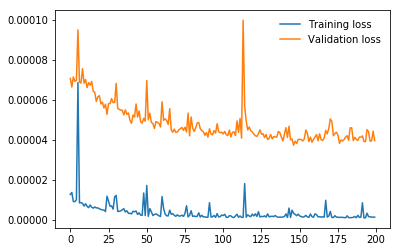

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)


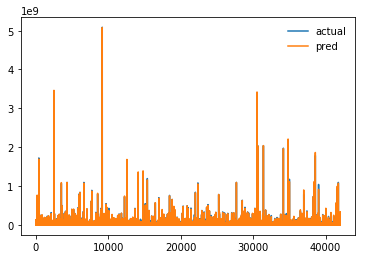

In [24]:
model.eval()
label = y_train.cpu()
label = y_scaler.inverse_transform(label)
with torch.no_grad():
    pred = model(X_train)
    pred = pred.cpu().numpy()
    pred = y_scaler.inverse_transform(pred)
    plot(label, pred)

## Submission 

In [25]:
pred = test_func(model, X_test)

In [26]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)
submission

,building_id,total_price
0,X5gsdTWGS3W7JJQB,126830184.0
1,BTshNOJyKHnT2YIT,10650551.0
2,dhdymr0lV8N5kZOT,56349608.0
3,VEwyGGMcD56w5BOc,34320132.0
4,wmUeMoJZfsqaSX9b,9784370.0
5,EtBjGAHmHCe9t7TZ,24112124.0
6,hPNH34vmaZtvBtqc,57999064.0
7,wXjeI38bYDMJJwZC,45751992.0
8,fxZSGX6aPAFKU8W4,20497458.0
9,ewr0Fx6ign87OwaV,24547774.0


## overfitting

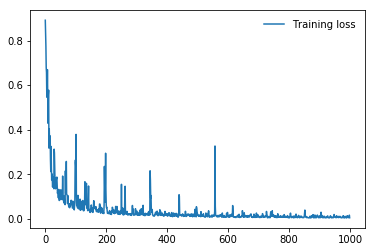

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

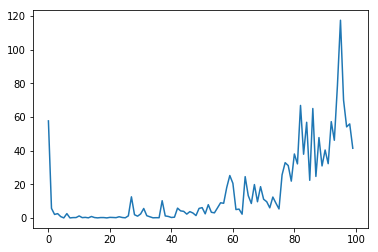

In [19]:
plt.plot(eval_losses, label='Validation loss')


## overfitting2

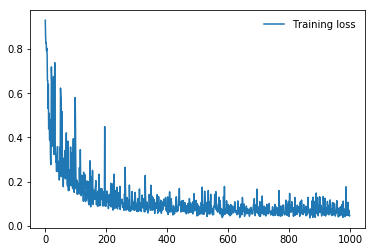

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

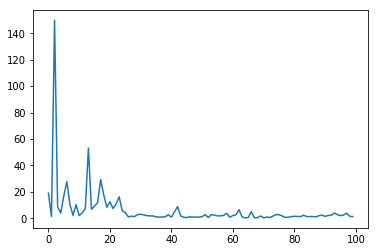

In [19]:
plt.plot(eval_losses, label='Validation loss')


### Submission

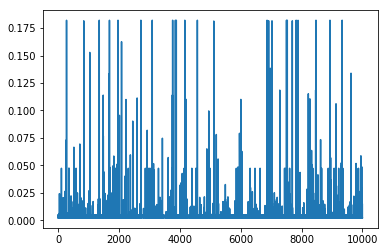

In [26]:
plt.plot(pred, label='pred')


### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512